![Vision Transformer](https://learnopencv.com/wp-content/uploads/2023/02/image-9.png)

#### Set logs to errors only

In [1]:
import transformers, datasets

transformers.utils.logging.set_verbosity_error

datasets.logging.CRITICAL
transformers.logging.CRITICAL
transformers.logging.set_verbosity_error()

# Image Classification Using Vision Transformers

Image classification assigns a label or class to an image. Unlike text or audio classification, the inputs are the pixel values that comprise an image. There are many applications for image classification, such as detecting damage after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

This guide illustrates how to:

    1. Fine-tune ViT on the Food-101 dataset to classify a food item in an image.
    
    2. Use your fine-tuned model for inference.
    

### Load Dataset

Start by loading a smaller subset of the Food-101 dataset from the 🤗 Datasets library. This will give you a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [2]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:20000]")

Found cached dataset food101 (C:/Users/sohail/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [3]:
food = food.train_test_split(test_size=0.2)


In [4]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>,
 'label': 14}

Each example in the dataset has two fields:

    1. image: a PIL image of the food item
    
    2. label: the label class of the food item
    
To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [5]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

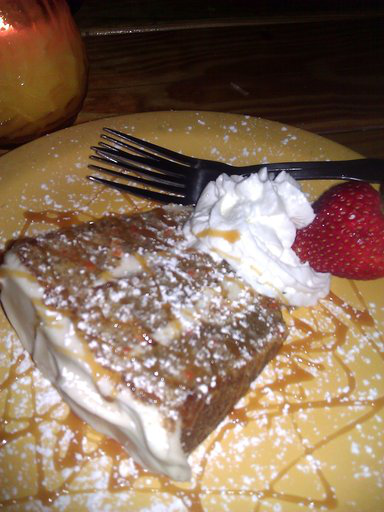

In [6]:
food["train"][0]['image']

In [7]:
id2label[str(20)]

'chicken_wings'

### Preprocess

The next step is to load a ViT image processor to process the image into a tensor:

In [107]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Apply some image transformations to the images to make the model more robust against overfitting. Here you’ll use torchvision’s transforms module, but you can also use any image library you like.

Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [108]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Then create a preprocessing function to apply the transforms and return the pixel_values - the inputs to the model - of the image:

In [109]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

To apply the preprocessing function over the entire dataset, use 🤗 Datasets with_transform method. The transforms are applied on the fly when you load an element of the dataset:

In [110]:
food = food.with_transform(transforms)

Now create a batch of examples using DefaultDataCollator. Unlike other data collators in 🤗 Transformers, the DefaultDataCollator does not apply additional preprocessing such as padding.

In [111]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

### Evaluate

Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load an evaluation method with the 🤗 Evaluate library. For this task, load the accuracy metric (see the 🤗 Evaluate quick tour to learn more about how to load and compute a metric):

In [112]:
import evaluate

accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to compute to calculate the accuracy:

In [113]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Your compute_metrics function is ready to go now, and you’ll return to it when you set up your training.

### Train

You’re ready to start training your model now! Load ViT with AutoModelForImageClassification. Specify the number of labels along with the number of expected labels, and the label mappings:

In [114]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

At this point, only three steps remain:

    1. Define your training hyperparameters in TrainingArguments. It is important you don’t remove unused columns because this’ll drop the image column. Without the image column, you can’t create pixel_values. Set remove_unused_columns=False to prevent this behavior! The only other required parameter is output_dir which specifies where to save your model. You’ll push this model to the Hub by setting push_to_hub=True (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the Trainer will evaluate the accuracy and save the training checkpoint.
    
    2. Pass the training arguments to Trainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
    
    3. Call train() to finetune your model.

In [115]:
training_args = TrainingArguments(
    output_dir="food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
#     push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [116]:
trainer.train()

C:\Users\sohail\anaconda3\envs\python_3_gpss\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 4.6312, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}
{'loss': 4.6054, 'learning_rate': 1.3333333333333333e-05, 'epoch': 0.08}
{'loss': 4.5575, 'learning_rate': 2e-05, 'epoch': 0.12}
{'loss': 4.4867, 'learning_rate': 2.6666666666666667e-05, 'epoch': 0.16}
{'loss': 4.3509, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.2}
{'loss': 4.1778, 'learning_rate': 4e-05, 'epoch': 0.24}
{'loss': 3.9932, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.28}
{'loss': 3.812, 'learning_rate': 4.962962962962963e-05, 'epoch': 0.32}
{'loss': 3.6379, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.36}
{'loss': 3.4569, 'learning_rate': 4.814814814814815e-05, 'epoch': 0.4}
{'loss': 3.2816, 'learning_rate': 4.740740740740741e-05, 'epoch': 0.44}
{'loss': 3.1662, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.48}
{'loss': 3.0097, 'learning_rate': 4.592592592592593e-05, 'epoch': 0.52}
{'loss': 2.871, 'learning_rate': 4.518518518518519e-05, 'epoch': 0.56}
{'loss': 2.7919, 'learnin

TrainOutput(global_step=750, training_loss=1.938803268432617, metrics={'train_runtime': 1243.4156, 'train_samples_per_second': 38.603, 'train_steps_per_second': 0.603, 'train_loss': 1.938803268432617, 'epoch': 3.0})

In [117]:
trainer.save_model('food_model')

### Inference

Great, now that you’ve fine-tuned a model, you can use it for inference!

Load an image you’d like to run inference on:

In [118]:
ds = load_dataset("food101", split="validation[3000:4200]")
image = ds["image"][145]

Found cached dataset food101 (C:/Users/sohail/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [119]:
from PIL import Image

image = Image.open(r"pork-steaks-featured.jpg") 


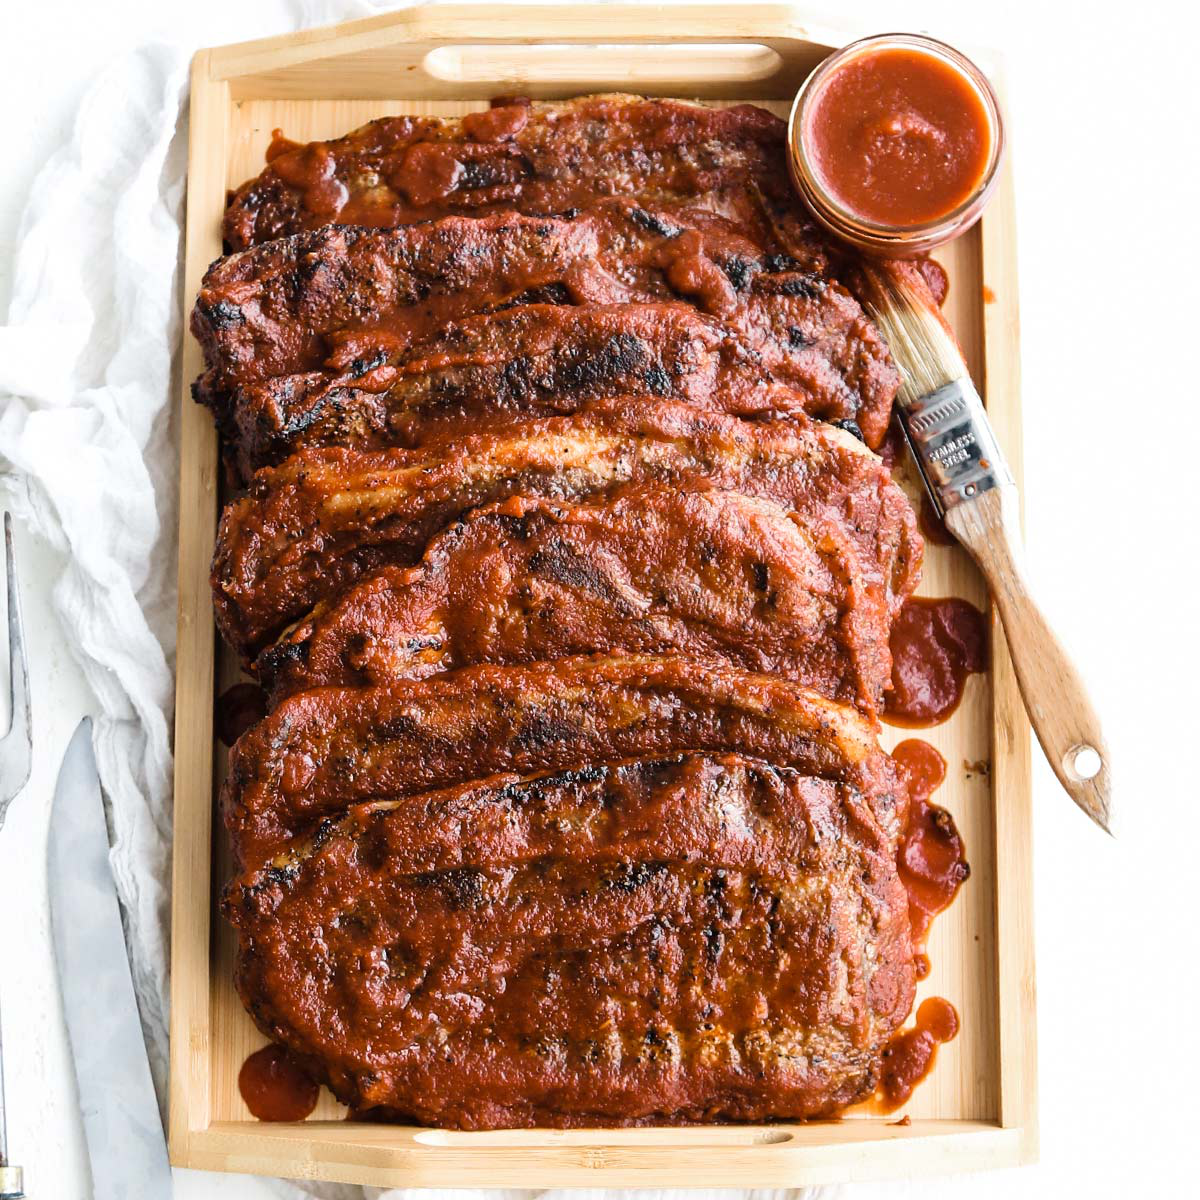

In [120]:
image

Load an image processor to preprocess the image and return the input as PyTorch tensors:

In [121]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("food_model")
inputs = image_processor(image, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [122]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("food_model")
with torch.no_grad():
    logits = model(**inputs).logits

Get the predicted label with the highest probability, and use the model’s id2label mapping to convert it to a label:

In [123]:
predicted_label = logits.argmax(-1).item()

model.config.id2label[predicted_label]

'steak'

# Image Segmentation

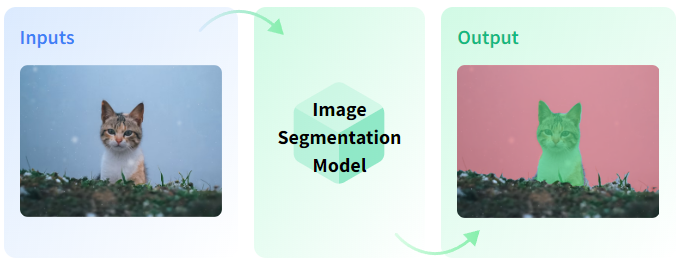

Semantic segmentation assigns a label or class to each individual pixel of an image. There are several types of segmentation, and in the case of semantic segmentation, no distinction is made between unique instances of the same object. Both objects are given the same label (for example, “cat” instead of “cat-1” and “cat-2”). Common real-world applications of semantic segmentation include training self-driving cars to identify pedestrians and important traffic information, identifying cells and abnormalities in medical imagery, and monitoring environmental changes from satellite imagery.

This guide will show you how to:

    1. Finetune SegFormer (a transformer model) on the SceneParse150 dataset.
    2. Use your finetuned model for inference.

### Load Dataset

Start by loading a smaller subset of the SceneParse150 dataset from the 🤗 Datasets library. This’ll give you a chance to experiment and make sure everything works before spending more time training on the full dataset.

In [2]:
from datasets import load_dataset
import torch
import torch.nn as nn

ds = load_dataset("scene_parse_150", split="train[:50]")

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (C:/Users/sohail/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


Split the dataset’s train split into a train and test set with the train_test_split method:

In [3]:
ds = ds.train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

Then take a look at an example:

In [4]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=402x536>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=402x536>,
 'scene_category': 4}

1. image: a PIL image of the scene.

2. annotation: a PIL image of the segmentation map, which is also the model’s target.

3. scene_category: a category id that describes the image scene like “kitchen” or “office”. In this guide, you’ll only need image and annotation, both of which are PIL images.

You’ll also want to create a dictionary that maps a label id to a label class which will be useful when you set up the model later. Download the mappings from the Hub and create the id2label and label2id dictionaries:

In [5]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"

filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

C:\Users\sohail\anaconda3\envs\python_3_gpss\lib\site-packages\huggingface_hub\file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [35]:
label2id

{'wall': 0,
 'building': 1,
 'sky': 2,
 'floor': 3,
 'tree': 4,
 'ceiling': 5,
 'road': 6,
 'bed ': 7,
 'windowpane': 8,
 'grass': 9,
 'cabinet': 10,
 'sidewalk': 11,
 'person': 12,
 'earth': 13,
 'door': 14,
 'table': 15,
 'mountain': 16,
 'plant': 17,
 'curtain': 18,
 'chair': 19,
 'car': 20,
 'water': 21,
 'painting': 22,
 'sofa': 23,
 'shelf': 24,
 'house': 25,
 'sea': 26,
 'mirror': 27,
 'rug': 28,
 'field': 29,
 'armchair': 30,
 'seat': 31,
 'fence': 32,
 'desk': 33,
 'rock': 34,
 'wardrobe': 35,
 'lamp': 36,
 'bathtub': 37,
 'railing': 38,
 'cushion': 39,
 'base': 40,
 'box': 41,
 'column': 42,
 'signboard': 43,
 'chest of drawers': 44,
 'counter': 45,
 'sand': 46,
 'sink': 47,
 'skyscraper': 48,
 'fireplace': 49,
 'refrigerator': 50,
 'grandstand': 51,
 'path': 52,
 'stairs': 53,
 'runway': 54,
 'case': 55,
 'pool table': 56,
 'pillow': 57,
 'screen door': 58,
 'stairway': 59,
 'river': 60,
 'bridge': 61,
 'bookcase': 62,
 'blind': 63,
 'coffee table': 64,
 'toilet': 65,
 'flow

### Preprocess

The next step is to load a SegFormer image processor to prepare the images and annotations for the model. Some datasets, like this one, use the zero-index as the background class. However, the background class isn’t actually included in the 150 classes, so you’ll need to set reduce_labels=True to subtract one from all the labels. The zero-index is replaced by 255 so it’s ignored by SegFormer’s loss function:

In [6]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
C:\Users\sohail\anaconda3\envs\python_3_gpss\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


It is common to apply some data augmentations to an image dataset to make a model more robust against overfitting. In this guide, you’ll use the ColorJitter function from torchvision to randomly change the color properties of an image, but you can also use any image library you like.

In [7]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Now create two preprocessing functions to prepare the images and annotations for the model. These functions convert the images into pixel_values and annotations to labels. For the training set, jitter is applied before providing the images to the image processor. For the test set, the image processor crops and normalizes the images, and only crops the labels because no data augmentation is applied during testing.

In [8]:
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

To apply the jitter over the entire dataset, use the 🤗 Datasets set_transform function. The transform is applied on the fly which is faster and consumes less disk space:

In [9]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

### Evaluate

In [10]:
import evaluate

metric = evaluate.load("mean_iou")

Then create a function to compute the metrics. Your predictions need to be converted to logits first, and then reshaped to match the size of the labels before you can call compute:

In [11]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

Your compute_metrics function is ready to go now, and you’ll return to it when you setup your training.

### Train

You’re ready to start training your model now! Load SegFormer with AutoModelForSemanticSegmentation, and pass the model the mapping between label ids and label classes:

In [12]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.runn

At this point, only three steps remain:

    1. Define your training hyperparameters in TrainingArguments. It is important you don’t remove unused columns because this’ll drop the image column. Without the image column, you can’t create pixel_values. Set remove_unused_columns=False to prevent this behavior! The only other required parameter is output_dir which specifies where to save your model. You’ll push this model to the Hub by setting push_to_hub=True (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the Trainer will evaluate the IoU metric and save the training checkpoint.

    2. Pass the training arguments to Trainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.

    3. Call train() to finetune your model.

In [13]:
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
#     push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)



In [148]:
trainer.train()

{'loss': 4.7113, 'learning_rate': 5.8740000000000003e-05, 'epoch': 0.05}
{'loss': 4.612, 'learning_rate': 5.868e-05, 'epoch': 0.1}
{'loss': 4.6908, 'learning_rate': 5.862e-05, 'epoch': 0.15}
{'loss': 4.6944, 'learning_rate': 5.856e-05, 'epoch': 0.2}
{'loss': 4.5851, 'learning_rate': 5.85e-05, 'epoch': 0.25}
{'loss': 4.589, 'learning_rate': 5.844e-05, 'epoch': 0.3}
{'loss': 4.5435, 'learning_rate': 5.838e-05, 'epoch': 0.35}
{'loss': 4.5535, 'learning_rate': 5.832e-05, 'epoch': 0.4}
{'loss': 4.4197, 'learning_rate': 5.826e-05, 'epoch': 0.45}
{'loss': 4.3842, 'learning_rate': 5.82e-05, 'epoch': 0.5}
{'loss': 4.3745, 'learning_rate': 5.814e-05, 'epoch': 0.55}
{'loss': 4.5552, 'learning_rate': 5.808e-05, 'epoch': 0.6}
{'loss': 4.3844, 'learning_rate': 5.802e-05, 'epoch': 0.65}
{'loss': 4.5053, 'learning_rate': 5.796e-05, 'epoch': 0.7}
{'loss': 4.4952, 'learning_rate': 5.79e-05, 'epoch': 0.75}
{'loss': 4.5061, 'learning_rate': 5.784e-05, 'epoch': 0.8}
{'loss': 4.3669, 'learning_rate': 5.778e

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 4.407940864562988, 'eval_mean_iou': 0.03664775499137051, 'eval_mean_accuracy': 0.12069075191355454, 'eval_overall_accuracy': 0.3955242712583718, 'eval_per_category_iou': [0.4447976240448986, nan, nan, 0.3426553793835767, 0.0, 0.3461624634552857, nan, 0.0, 0.019287781255536526, nan, 0.2939892502965, nan, 0.0, 0.0, 0.18710361805221343, 0.0, nan, 0.0, 0.07201118620368213, 0.0, nan, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.05511957954915957, 0.0, nan, nan, 0.0, nan, nan, nan, nan, 0.0, 0.20431916221275673, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.12772385347979773, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, 0.0024768936360798576, 0.0, nan, nan, nan, nan, nan, 0.04249276480802624, 0.0, nan, 0.0, nan, 0.0004626416840157298, 0.0, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.023615346429331253, 0.0, nan, nan, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, 0.0, nan, nan, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 3.8099453449249268, 'eval_mean_iou': 0.0641541128329059, 'eval_mean_accuracy': 0.12685948822569684, 'eval_overall_accuracy': 0.45312134449426095, 'eval_per_category_iou': [0.4887543657141585, nan, nan, 0.4100140124573823, nan, 0.3769406733303496, nan, nan, 0.10354188660858267, nan, 0.21886128393077361, nan, nan, nan, 0.24615340814342715, 0.0, nan, nan, 0.03982607948020364, 0.0, nan, nan, 0.0, 0.0, 0.0, nan, nan, 0.04345692352716058, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.19304496271508892, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.12753639533463032, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0018650010511824108, nan, nan, nan, nan, nan, nan, 0.027972104531371455, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.031580965160300956, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 3.5292420387268066, 'eval_mean_iou': 0.0737205036665744, 'eval_mean_accuracy': 0.13915687987703707, 'eval_overall_accuracy': 0.44287463072518435, 'eval_per_category_iou': [0.478221265725906, nan, nan, 0.3751982770249841, nan, 0.3593811006891792, nan, nan, 0.0894791158692176, nan, 0.39553987859469847, nan, 0.0, nan, 0.26333753706963714, 0.0, nan, nan, 0.01763327257170492, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.04446700091251166, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.23399316525888195, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.1551565876982902, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.018259470165882644, nan, nan, nan, nan, nan, nan, 0.08464733018485443, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.06490362656435553, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 3.3673388957977295, 'eval_mean_iou': 0.07947642923500471, 'eval_mean_accuracy': 0.14472508738840392, 'eval_overall_accuracy': 0.4719387132779766, 'eval_per_category_iou': [0.5029146276348596, nan, nan, 0.4400322101434184, nan, 0.3656724168371639, nan, nan, 0.11321210170582556, nan, 0.38590341114548593, nan, 0.0, nan, 0.2751397066609658, 0.0, nan, nan, 0.024422718922983984, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.04212878326223847, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.23492719612956803, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.16534125226494867, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.010780950393279679, nan, nan, nan, nan, nan, nan, 0.17704727353291425, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.04415237459151301, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 3.2365448474884033, 'eval_mean_iou': 0.08631197171476777, 'eval_mean_accuracy': 0.14993708905721093, 'eval_overall_accuracy': 0.4917266844470466, 'eval_per_category_iou': [0.5228773520919326, nan, nan, 0.4738416522700036, nan, 0.3838284918705902, nan, nan, 0.16296646717127267, nan, 0.4618271198894351, nan, nan, nan, 0.29033450604093375, 0.0, nan, nan, 0.0063854162101928775, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03726507534858576, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.24620378978556798, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.15789619109459405, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.009311388837758412, nan, nan, nan, nan, nan, nan, 0.1422376679288345, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.03963191976240323, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.981835126876831, 'eval_mean_iou': 0.09131298944300426, 'eval_mean_accuracy': 0.1541572266972646, 'eval_overall_accuracy': 0.5125960354471829, 'eval_per_category_iou': [0.5439827616516161, nan, nan, 0.43267869921284885, nan, 0.41399200606076436, nan, nan, 0.14554615349620126, nan, 0.556690946930281, nan, nan, nan, 0.29273715863873395, 0.0, nan, nan, 0.04344465536751112, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03483512552345279, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2427040940554454, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.17319370751119217, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.010997410436008777, nan, nan, nan, nan, nan, nan, 0.1512984166693394, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.06254050550874919, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.9320731163024902, 'eval_mean_iou': 0.09404963248973366, 'eval_mean_accuracy': 0.1618868009776117, 'eval_overall_accuracy': 0.49932353772771865, 'eval_per_category_iou': [0.5225066610055811, nan, nan, 0.479907193938237, nan, 0.4117670698870715, nan, nan, 0.19893446020400943, nan, 0.46728333253866083, nan, nan, nan, 0.280311790039668, 0.0, nan, nan, 0.0010352935306627749, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.06620170803079993, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2709549447435534, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.20311334824757643, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0046957942017149855, nan, nan, nan, nan, nan, nan, 0.23215380808417702, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.05882210019923223, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.790825605392456, 'eval_mean_iou': 0.08977456698152857, 'eval_mean_accuracy': 0.1587804917192184, 'eval_overall_accuracy': 0.5114878610714858, 'eval_per_category_iou': [0.5371515549877733, nan, nan, 0.4443873997130496, nan, 0.4210509535525078, nan, nan, 0.1857360052126796, nan, 0.344123222486888, nan, nan, nan, 0.336841684849555, 0.0, nan, nan, 0.02608727806092578, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03852560396092682, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.25018159630415204, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.19471512857290726, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.007833678968684787, nan, nan, nan, nan, nan, nan, 0.2195232227236057, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.04617794797831601, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.835134744644165, 'eval_mean_iou': 0.08924032799568274, 'eval_mean_accuracy': 0.15955984587244398, 'eval_overall_accuracy': 0.5035130847359478, 'eval_per_category_iou': [0.5283937229287115, nan, nan, 0.4336329057185856, nan, 0.42017675201782645, nan, nan, 0.18993054839972798, nan, 0.41005391754023773, nan, nan, nan, 0.31329570561435216, 0.0, nan, nan, 0.08343716514241571, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.044702397403462525, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.22369117135817895, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.16869985479751143, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0072570376772201585, nan, nan, nan, nan, nan, nan, 0.14884893008157862, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.062051043173404596, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.664210081100464, 'eval_mean_iou': 0.08890397825975639, 'eval_mean_accuracy': 0.14926350453647313, 'eval_overall_accuracy': 0.5071451452484275, 'eval_per_category_iou': [0.5351961197653277, nan, nan, 0.49964014214385316, nan, 0.3434340757621931, nan, nan, 0.1665555446612413, nan, 0.4822520339554215, nan, nan, nan, 0.2900768291807281, 0.0, nan, nan, 0.015540929452689006, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.05213954548909326, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2551078616478528, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.17161776284092645, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.009576864891537947, nan, nan, nan, nan, nan, nan, 0.1477686102153931, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.05382894082545997, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.5558173656463623, 'eval_mean_iou': 0.09103651414430447, 'eval_mean_accuracy': 0.15435215852396966, 'eval_overall_accuracy': 0.5147979871298204, 'eval_per_category_iou': [0.5396579731463169, nan, nan, 0.48530218257119656, nan, 0.22915039028132633, nan, nan, 0.23764184741365618, nan, 0.4138505681474563, nan, nan, nan, 0.2988669141361894, 0.0, nan, nan, 0.09646597098685056, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.06088523216121441, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2204614956908535, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.19795324880164628, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.010819031932415919, nan, nan, nan, nan, nan, nan, 0.23004436622300445, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.07414225941422595, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.51953387260437, 'eval_mean_iou': 0.09253066118589258, 'eval_mean_accuracy': 0.1576859231246679, 'eval_overall_accuracy': 0.5178329692074694, 'eval_per_category_iou': [0.5203384008185937, nan, nan, 0.5064232610307863, nan, 0.4028855157743841, nan, nan, 0.2311697674884345, nan, 0.389573520458842, nan, nan, nan, 0.296831935646782, 0.0, nan, nan, 0.04545936340680238, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.062173379479613364, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2714246326510753, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.16235191842989333, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.018771995937737523, nan, nan, nan, nan, nan, nan, 0.19832523936537624, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.040313549832026875, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.427201747894287, 'eval_mean_iou': 0.10658668011817422, 'eval_mean_accuracy': 0.16963275885581744, 'eval_overall_accuracy': 0.5364763734103737, 'eval_per_category_iou': [0.5328684651901949, nan, nan, 0.5257449549710437, nan, 0.390444944551395, nan, nan, 0.2546539677658072, nan, 0.5412700615142685, nan, nan, nan, 0.35156016512253435, 0.0, nan, nan, 0.18634055405250002, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.04760179041641446, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2702418708646607, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.1920444430803229, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.03548817450936794, nan, nan, nan, nan, nan, nan, 0.22496190608117467, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0707258258982397, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.307854413986206, 'eval_mean_iou': 0.0974145589370391, 'eval_mean_accuracy': 0.145020118960148, 'eval_overall_accuracy': 0.5284404095326192, 'eval_per_category_iou': [0.5098254027792097, nan, nan, 0.5335212879543885, nan, 0.2641465278112374, nan, nan, 0.19603241879794076, nan, 0.5823908108954289, nan, nan, nan, 0.2933801932973516, 0.0, nan, nan, 0.11448056348185034, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03584446151583008, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26050362732749444, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.17821944271634851, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.025353491591035688, nan, nan, nan, nan, nan, nan, 0.2262229920280683, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.09217378366314537, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.363507032394409, 'eval_mean_iou': 0.09243189724674074, 'eval_mean_accuracy': 0.15410356417424925, 'eval_overall_accuracy': 0.5211934850064527, 'eval_per_category_iou': [0.5313653857566122, nan, nan, 0.49302817464666904, nan, 0.16030660597824134, nan, nan, 0.2321007387770219, nan, 0.437296260102289, nan, nan, nan, 0.350102166607562, 0.0, nan, nan, 0.05880509058993166, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.07977834113042055, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.270543191705404, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.17731890983691384, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.054861104613628496, nan, nan, nan, nan, nan, nan, 0.2385659789162804, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.05861255772821067, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.259542942047119, 'eval_mean_iou': 0.09911843069807809, 'eval_mean_accuracy': 0.15342074833756555, 'eval_overall_accuracy': 0.5331866431994446, 'eval_per_category_iou': [0.5259465672601881, nan, nan, 0.5257291937057859, nan, 0.22195797787620272, nan, nan, 0.24483132823170617, nan, 0.5077726630358427, nan, nan, nan, 0.28520161987437065, 0.0, nan, nan, 0.12070814128318257, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.037341056311478216, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26094813070678585, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.18553512875102954, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.050109949048002145, nan, nan, nan, nan, nan, nan, 0.27388568159359233, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.1300592060564884, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.227428913116455, 'eval_mean_iou': 0.10701700950480096, 'eval_mean_accuracy': 0.16631277212873555, 'eval_overall_accuracy': 0.5315813700330613, 'eval_per_category_iou': [0.5131027716316203, nan, nan, 0.5272474672053854, nan, 0.3877927912281311, nan, nan, 0.23200824558921607, nan, 0.4838955048092652, nan, nan, nan, 0.3347112749906972, 0.0, nan, nan, 0.20811508933055894, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.05607251140388415, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.24118479452517905, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.19250669792364367, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.05507223400249698, nan, nan, nan, nan, nan, nan, 0.26402877697841726, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.14284016354473708, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.24753999710083, 'eval_mean_iou': 0.10428155218413136, 'eval_mean_accuracy': 0.16659048902293536, 'eval_overall_accuracy': 0.5217521712579319, 'eval_per_category_iou': [0.517763150890971, nan, nan, 0.5172321728003543, nan, 0.2725375325666086, nan, nan, 0.22921033547579547, nan, 0.42244537214637634, nan, nan, nan, 0.3216553377744099, 0.0, nan, nan, 0.22214652583188688, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.041765904576838084, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.3213706673677753, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.20495106113614397, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.09715635245664796, nan, nan, nan, nan, nan, nan, 0.2902968442413258, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0870415169953327, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.199324607849121, 'eval_mean_iou': 0.09898780145644646, 'eval_mean_accuracy': 0.1559160734059591, 'eval_overall_accuracy': 0.5273690276659672, 'eval_per_category_iou': [0.5199420256474716, nan, nan, 0.5061636863996783, nan, 0.24872932066173883, nan, nan, 0.2685540769849067, nan, 0.4577958603655803, nan, nan, nan, 0.3194121596010431, 0.0, nan, nan, 0.1646819151021281, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03437312943993314, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.27432864255113487, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.20805152235636296, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0463357177329568, nan, nan, nan, nan, nan, nan, 0.26252203486405157, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.05469515781219369, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.1462645530700684, 'eval_mean_iou': 0.11228353579054172, 'eval_mean_accuracy': 0.17347144810047413, 'eval_overall_accuracy': 0.5544155209999244, 'eval_per_category_iou': [0.5481055685283938, nan, nan, 0.5139764564104656, nan, 0.3781088599903495, nan, nan, 0.2367157318206269, nan, 0.5003221784282713, nan, nan, nan, 0.3386034447585463, 0.0, nan, nan, 0.27517666661309076, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03347828563832817, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.27059539867313326, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2043721721990772, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.05581661037154778, nan, nan, nan, nan, nan, nan, 0.2559059773858147, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.20646286606077296, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.1429200172424316, 'eval_mean_iou': 0.10254698972669903, 'eval_mean_accuracy': 0.1518473487543115, 'eval_overall_accuracy': 0.5291834582479007, 'eval_per_category_iou': [0.5117777643908797, nan, nan, 0.5383096111418946, nan, 0.19217657595192697, nan, nan, 0.2290349948999533, nan, 0.5616877509606666, nan, nan, nan, 0.27342426744579945, 0.0, nan, nan, 0.12113817228860625, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03663038484085112, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2514200136147039, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2366363658322531, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.11057062763840238, nan, nan, nan, nan, nan, nan, 0.2719310170709444, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.15186010463088548, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.0698976516723633, 'eval_mean_iou': 0.10624375750874535, 'eval_mean_accuracy': 0.15686680551419632, 'eval_overall_accuracy': 0.5435253382411341, 'eval_per_category_iou': [0.5301778579496603, nan, nan, 0.551355410914813, nan, 0.17974210696454868, nan, nan, 0.2231477334925611, nan, 0.516696636195031, nan, nan, nan, 0.33758990930887106, 0.0, nan, nan, 0.23029551042710136, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03407033205310082, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.24609496810772502, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2047778451519657, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.06120239232250387, nan, nan, nan, nan, nan, nan, 0.3009589082273725, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.196178144182087, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.08711576461792, 'eval_mean_iou': 0.10563000083998915, 'eval_mean_accuracy': 0.16132674476312434, 'eval_overall_accuracy': 0.547507727426696, 'eval_per_category_iou': [0.5404321931684433, nan, nan, 0.5138268421928095, nan, 0.20868177738520935, nan, nan, 0.22797182127198384, nan, 0.4441682923169268, nan, nan, nan, 0.3268825717036364, 0.0, nan, nan, 0.23249243878405396, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03498068356942304, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2505757642679118, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.22852129869484974, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.08446994504399329, nan, nan, nan, nan, nan, nan, 0.2894666799747147, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.20894972018567523, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.0460026264190674, 'eval_mean_iou': 0.11332601801051456, 'eval_mean_accuracy': 0.1755102863988563, 'eval_overall_accuracy': 0.5516472846128528, 'eval_per_category_iou': [0.5411073985121309, nan, nan, 0.5528060394232266, nan, 0.28570982975564413, nan, nan, 0.26118054366641935, nan, 0.44545201108925614, nan, nan, nan, 0.35155787067454425, 0.0, nan, nan, 0.26021725012627595, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03239119999063331, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.28862257161997085, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.22316128806195032, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1153351605589957, nan, nan, nan, nan, nan, nan, 0.3011997046880768, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.19434374419036995, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 2.08945894241333, 'eval_mean_iou': 0.10858406437105637, 'eval_mean_accuracy': 0.16037470092471756, 'eval_overall_accuracy': 0.5381252377016039, 'eval_per_category_iou': [0.5127618327046616, nan, nan, 0.5380890160942425, nan, 0.35054261373678813, nan, nan, 0.1511139812721989, nan, 0.5341598065054936, nan, nan, nan, 0.26394225325036147, 0.0, nan, nan, 0.16886116748239227, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.040916853122023526, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26709781265269755, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2471023448460151, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.0984983021739979, nan, nan, nan, nan, nan, nan, 0.3103178346697711, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.20845437010527293, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.938307762145996, 'eval_mean_iou': 0.10573935157466294, 'eval_mean_accuracy': 0.152777128713903, 'eval_overall_accuracy': 0.5500572083523795, 'eval_per_category_iou': [0.5344118252751527, nan, nan, 0.5485278499762444, nan, 0.18407472777312434, nan, nan, 0.2102139151722396, nan, 0.5008461172618982, nan, nan, nan, 0.31506953155757045, 0.0, nan, nan, 0.23105359403572936, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.033715678829782984, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2603893327332058, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2051765120169029, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.09519738887161952, nan, nan, nan, nan, nan, nan, 0.26598798716088096, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.21047349287418873, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9806572198867798, 'eval_mean_iou': 0.10849036566281614, 'eval_mean_accuracy': 0.16059158939664275, 'eval_overall_accuracy': 0.5442135981114246, 'eval_per_category_iou': [0.5262245659909066, nan, nan, 0.532811901194997, nan, 0.21614559807648207, nan, nan, 0.19963283658282774, nan, 0.47659407878639587, nan, nan, nan, 0.31361033995342547, 0.0, nan, nan, 0.23234541003122122, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03922479020498005, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.271756378024152, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.22636966594990762, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.11297525274452645, nan, nan, nan, nan, nan, nan, 0.27947422452142756, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.26150739047449956, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9801242351531982, 'eval_mean_iou': 0.11076294731641045, 'eval_mean_accuracy': 0.1693425702551362, 'eval_overall_accuracy': 0.5472645769321366, 'eval_per_category_iou': [0.5372547753101306, nan, nan, 0.5298006469073866, nan, 0.21176590330788805, nan, nan, 0.2260673655581152, nan, 0.4659098656848708, nan, nan, nan, 0.33488896284642383, 0.0, nan, nan, 0.3069735725700246, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03305886827914886, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.257648207896089, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.22121575253250764, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.13624395409404425, nan, nan, nan, nan, nan, nan, 0.2569290389093955, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.24818329486193041, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9877897500991821, 'eval_mean_iou': 0.1177598556816459, 'eval_mean_accuracy': 0.17473569522100688, 'eval_overall_accuracy': 0.5596928465364451, 'eval_per_category_iou': [0.5459885673085387, nan, nan, 0.5332259502881023, nan, 0.28422335206721233, nan, nan, 0.22733035878475819, nan, 0.5561444428247152, nan, nan, nan, 0.3150547143270862, 0.0, nan, nan, 0.2762082440169135, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.034171579833955, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.27736119745588445, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.22985657649253732, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1531757922885808, nan, nan, nan, nan, nan, nan, 0.2839199362140557, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2871743812736213, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9476286172866821, 'eval_mean_iou': 0.11261695796910463, 'eval_mean_accuracy': 0.1659008081664823, 'eval_overall_accuracy': 0.5577372446969797, 'eval_per_category_iou': [0.5376832985614732, nan, nan, 0.5319274164493702, nan, 0.20890957252198855, nan, nan, 0.22160400604085526, nan, 0.515930704775613, nan, nan, nan, 0.32764782285843425, 0.0, nan, nan, 0.26351120838516323, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03439105427741791, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2715278096783908, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.24811555212887246, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.08329355078658421, nan, nan, nan, nan, nan, nan, 0.3211786272225684, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.26325594726282603, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9679796695709229, 'eval_mean_iou': 0.10928310070244901, 'eval_mean_accuracy': 0.1669149131394482, 'eval_overall_accuracy': 0.5468022710576127, 'eval_per_category_iou': [0.5382353994619016, nan, nan, 0.5059022689832807, nan, 0.20897420370594647, nan, nan, 0.2503977123985582, nan, 0.4076106584452764, nan, nan, nan, 0.2982215736228945, 0.0, nan, nan, 0.286723818954061, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03494501614205004, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.23431167301333675, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.23466352315701197, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1544234195059685, nan, nan, nan, nan, nan, nan, 0.3174660268276207, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.24375012966535964, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.950608491897583, 'eval_mean_iou': 0.11377464733274961, 'eval_mean_accuracy': 0.16964078790891213, 'eval_overall_accuracy': 0.548947434302376, 'eval_per_category_iou': [0.535108615135489, nan, nan, 0.5285336408967223, nan, 0.21358083220889099, nan, nan, 0.2196436966720349, nan, 0.5261316585252385, nan, nan, nan, 0.30523733475518006, 0.0, nan, nan, 0.23561767147149254, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.031846672827067164, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.28171502034701273, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.23070749475243857, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.160743855904388, nan, nan, nan, nan, nan, nan, 0.3357604227833235, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.26371109303420814, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8821218013763428, 'eval_mean_iou': 0.1116848143234664, 'eval_mean_accuracy': 0.16466607029102265, 'eval_overall_accuracy': 0.5520528020495027, 'eval_per_category_iou': [0.5318088326739235, nan, nan, 0.5247296421383004, nan, 0.20313950313950313, nan, nan, 0.2205112194335898, nan, 0.4242436715373534, nan, nan, nan, 0.32042474327742354, 0.0, nan, nan, 0.27870559811369633, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.033162784630324814, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26827053069490914, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2404473611239486, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.14538860880484286, nan, nan, nan, nan, nan, nan, 0.352718613573224, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2537325778568179, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9205518960952759, 'eval_mean_iou': 0.11278460413486717, 'eval_mean_accuracy': 0.16545512331633838, 'eval_overall_accuracy': 0.553334141168858, 'eval_per_category_iou': [0.5347296030009377, nan, nan, 0.5213348707407964, nan, 0.2701778385772914, nan, nan, 0.2311654171940415, nan, 0.4572223616084666, nan, nan, nan, 0.2600498098948371, 0.0, nan, nan, 0.27223003676028423, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03407489251995552, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2679958157055329, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.23242821308916137, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.13067706124756717, nan, nan, nan, nan, nan, nan, 0.3389535516153595, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.28363706863125243, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9209102392196655, 'eval_mean_iou': 0.11450543413869724, 'eval_mean_accuracy': 0.16457695556253987, 'eval_overall_accuracy': 0.5586206648326401, 'eval_per_category_iou': [0.5313619121056554, nan, nan, 0.5398057278398241, nan, 0.21995507959642044, nan, nan, 0.2119157837649383, nan, 0.4505743777574295, nan, nan, nan, 0.29197388755531206, 0.0, nan, nan, 0.25098225584518213, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03360922111851375, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.3000802606109249, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25569888838816285, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.15532918721852884, nan, nan, nan, nan, nan, nan, 0.3478739469805862, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.3040242319342276, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.907096266746521, 'eval_mean_iou': 0.11620583519745598, 'eval_mean_accuracy': 0.17247324905055864, 'eval_overall_accuracy': 0.557425308207249, 'eval_per_category_iou': [0.540107298014002, nan, nan, 0.5251181452826977, nan, 0.24899543032801008, nan, nan, 0.21274088102265515, nan, 0.5471154800913514, nan, nan, nan, 0.29509442594616575, 0.0, nan, nan, 0.24994586215935902, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03173177083333333, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2772316312935539, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25018594506054703, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.18450733477160694, nan, nan, nan, nan, nan, nan, 0.3401785968475094, 0.0, nan, nan, nan, 0.0006239800326389556, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.24742161503007254, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.883556604385376, 'eval_mean_iou': 0.11737575158888258, 'eval_mean_accuracy': 0.17148192688464856, 'eval_overall_accuracy': 0.5621647432582726, 'eval_per_category_iou': [0.5397380662399468, nan, nan, 0.5345300574641072, nan, 0.25320504021742113, nan, nan, 0.20711792320346667, nan, 0.5433289995379673, nan, nan, nan, 0.31949612518481035, 0.0, nan, nan, 0.2645020401749186, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.0310500965376978, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2989435803463997, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.24687692750524282, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.12136715911843061, nan, nan, nan, nan, nan, nan, 0.3452190433407268, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2854004951508721, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8870503902435303, 'eval_mean_iou': 0.11681463316343503, 'eval_mean_accuracy': 0.17006957255430047, 'eval_overall_accuracy': 0.5603235181317083, 'eval_per_category_iou': [0.5368373493776363, nan, nan, 0.5306220330201229, nan, 0.2582322003723686, nan, nan, 0.2409653548282101, nan, 0.5143464997692403, nan, nan, nan, 0.2896836062497781, 0.0, nan, nan, 0.27712553287261366, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.033553942233795694, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2791236417277846, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2488734835355286, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.13535904414481456, nan, nan, nan, nan, nan, nan, 0.3455543765028865, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2814204629220109, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, 

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8691279888153076, 'eval_mean_iou': 0.11693425271579333, 'eval_mean_accuracy': 0.17546078108937305, 'eval_overall_accuracy': 0.5624242904144716, 'eval_per_category_iou': [0.5521028895564393, nan, nan, 0.5124205349455618, nan, 0.24227807164195467, nan, nan, 0.2522942103190232, nan, 0.4718107885121597, nan, nan, nan, 0.3033447864806115, 0.0, nan, nan, 0.29051940489257866, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.030931053203040175, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2715187392413405, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.24324582886881985, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1655219032410264, nan, nan, nan, nan, nan, nan, 0.3703501313896769, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2694262500447403, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8846168518066406, 'eval_mean_iou': 0.11568189838041588, 'eval_mean_accuracy': 0.16688701882980006, 'eval_overall_accuracy': 0.5616848409663793, 'eval_per_category_iou': [0.5388185648451196, nan, nan, 0.5312696254684233, nan, 0.2159605507633399, nan, nan, 0.21236315909836637, nan, 0.46161687446091115, nan, nan, nan, 0.2926586642043706, 0.0, nan, nan, 0.2667867153292495, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.032557836334400486, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.27815918478507556, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25677581237168984, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.16261949068291315, nan, nan, nan, nan, nan, nan, 0.3941952229883852, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2894028436018957, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8597278594970703, 'eval_mean_iou': 0.11710219802284488, 'eval_mean_accuracy': 0.1731001364221085, 'eval_overall_accuracy': 0.559848414862734, 'eval_per_category_iou': [0.5407518675616462, nan, nan, 0.537993060723907, nan, 0.24264599781492857, nan, nan, 0.2567369412587277, nan, 0.43806352042888475, nan, nan, nan, 0.29448334092997885, 0.0, nan, nan, 0.2871411684325825, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03435214752761304, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2666942393513271, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.24201460808895672, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.18322500921992269, nan, nan, nan, nan, nan, nan, 0.3623936316222893, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2949791998159615, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8597180843353271, 'eval_mean_iou': 0.11703930547523289, 'eval_mean_accuracy': 0.1721304875635214, 'eval_overall_accuracy': 0.5632057313131047, 'eval_per_category_iou': [0.5433391483198458, nan, nan, 0.5285333405149197, nan, 0.23862012655644008, nan, nan, 0.23165690327383867, nan, 0.4598975834415828, nan, nan, nan, 0.28276045977474157, 0.0, nan, nan, 0.2973426130971212, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03423536209553159, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2745298594164309, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25429695200367974, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.17214405684416514, nan, nan, nan, nan, nan, nan, 0.38928608614167215, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2726938946779495, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8639202117919922, 'eval_mean_iou': 0.11813968576701059, 'eval_mean_accuracy': 0.1769330439975057, 'eval_overall_accuracy': 0.5629569819584732, 'eval_per_category_iou': [0.5460333485539697, nan, nan, 0.5289553043448961, nan, 0.25742853119278974, nan, nan, 0.24620261781122976, nan, 0.4426513548907021, nan, nan, nan, 0.29490240169589743, 0.0, nan, nan, 0.3067917196098111, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03263440897955172, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.275247592807923, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25673621541412567, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.18136912954129825, nan, nan, nan, nan, nan, nan, 0.3757634965807246, 0.0, nan, nan, nan, 0.002192459844621324, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.26984073481081994, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.9098001718521118, 'eval_mean_iou': 0.11512685443161952, 'eval_mean_accuracy': 0.17009670743604827, 'eval_overall_accuracy': 0.5600335771636895, 'eval_per_category_iou': [0.5418600914513722, nan, nan, 0.5342493700972142, nan, 0.22377980432586525, nan, nan, 0.22701364276350924, nan, 0.44327103381483235, nan, nan, nan, 0.28496978929181194, 0.0, nan, nan, 0.25568803826719083, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.034101382488479264, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2734898381101935, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25507802284020575, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.18873877921896373, nan, nan, nan, nan, nan, nan, 0.3695841948081783, 0.0, nan, nan, nan, 0.0019267822736030828, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.280562280923644, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8691784143447876, 'eval_mean_iou': 0.11444611796975458, 'eval_mean_accuracy': 0.16740909903396983, 'eval_overall_accuracy': 0.5576324660299163, 'eval_per_category_iou': [0.5377971269531562, nan, nan, 0.5337267192722129, nan, 0.2003288062902073, nan, nan, 0.2109294945133659, nan, 0.4604372422044732, nan, nan, nan, 0.2966321664205932, 0.0, nan, nan, 0.25423784874394295, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.032292242191816437, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.27470478204756466, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2573570578766884, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1790189084188667, nan, nan, nan, nan, nan, nan, 0.36246972691590346, 0.0, nan, nan, nan, 0.00043352601156069364, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.29080236311130403, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8621755838394165, 'eval_mean_iou': 0.11547223517528514, 'eval_mean_accuracy': 0.17067085305482427, 'eval_overall_accuracy': 0.5595340788615438, 'eval_per_category_iou': [0.541952295049108, nan, nan, 0.5256235389063599, nan, 0.22894753242436622, nan, nan, 0.2156199160457129, nan, 0.4425167593921403, nan, nan, nan, 0.30280154834116896, 0.0, nan, nan, 0.2736520909662454, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03186883921697316, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26137703710947613, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.26011523032102535, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.17161938575890007, nan, nan, nan, nan, nan, nan, 0.3850681509011212, 0.0, nan, nan, nan, 0.0010115606936416184, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2838821108334558, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, n

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8340950012207031, 'eval_mean_iou': 0.1156512775423679, 'eval_mean_accuracy': 0.16957207689447834, 'eval_overall_accuracy': 0.5606142589368804, 'eval_per_category_iou': [0.5398573736661058, nan, nan, 0.5275171249741045, nan, 0.23776577325299536, nan, nan, 0.23155397621883358, nan, 0.44461544775506856, nan, nan, nan, 0.30119990623443343, 0.0, nan, nan, 0.2723463535737904, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03214422175136337, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.26827068878371546, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2590555218870915, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.1555719557195572, nan, nan, nan, nan, nan, nan, 0.38036416872540946, 0.0, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2818809238980399, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.0, nan

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8407678604125977, 'eval_mean_iou': 0.11654091021542223, 'eval_mean_accuracy': 0.17191696493805828, 'eval_overall_accuracy': 0.5606938427336194, 'eval_per_category_iou': [0.5422989180272736, nan, nan, 0.5263783707742858, nan, 0.2432152690086323, nan, nan, 0.23002153484729834, nan, 0.4571303809165964, nan, nan, nan, 0.3005996350047797, 0.0, nan, nan, 0.27802136759051027, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03206166376581747, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.265900038545548, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.2573375451263538, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.17284719470078697, nan, nan, nan, nan, nan, nan, 0.3729591370326355, 0.0, nan, nan, nan, 0.003371868978805395, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2802480230050324, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, nan,

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 1.8696759939193726, 'eval_mean_iou': 0.11640899695607458, 'eval_mean_accuracy': 0.17195176291152736, 'eval_overall_accuracy': 0.559843615839815, 'eval_per_category_iou': [0.5407636009975604, nan, nan, 0.523942979150133, nan, 0.24202961164715645, nan, nan, 0.2235081338578008, nan, 0.46244516725851215, nan, nan, nan, 0.29893404413774427, 0.0, nan, nan, 0.26821975763472483, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, 0.03214617487251803, 0.0, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.2657893176833244, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, 0.25980910034633864, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, 0.17594072756085016, nan, nan, nan, nan, nan, nan, 0.3773153359206865, 0.0, nan, nan, nan, 0.004913294797687861, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.2821486506414983, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, 0.0, nan, nan, nan, na

C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\sohail\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


TrainOutput(global_step=1000, training_loss=1.8498178114891053, metrics={'train_runtime': 716.7502, 'train_samples_per_second': 2.79, 'train_steps_per_second': 1.395, 'train_loss': 1.8498178114891053, 'epoch': 50.0})

### Inference

Great, now that you’ve finetuned a model, you can use it for inference!

Load an image for inference:

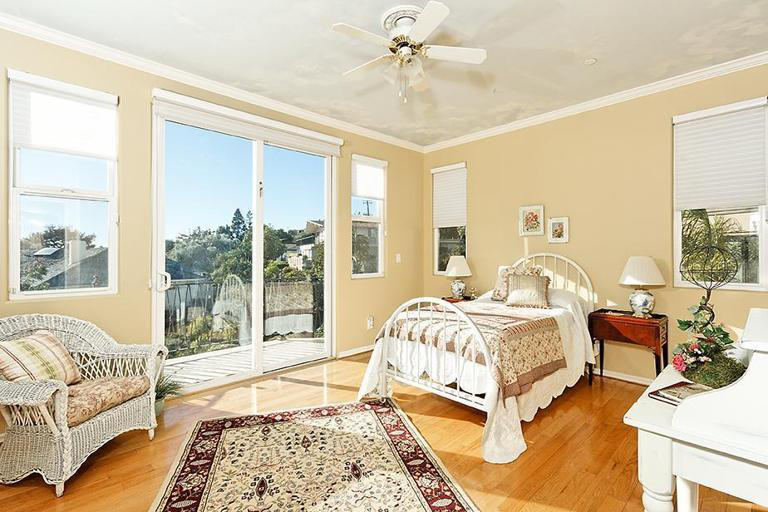

In [27]:
# image = ds[0]["image"]
# image

from PIL import Image

image = Image.open(r"image.jpg") 
image

Process the image with an image processor and place the pixel_values on a GPU:

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

Load trained model, and pass your input to the model and return the logits:

In [30]:
checkpoint = "segformer-b0-scene-parse-150"
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
model.to('cuda')

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [39]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

In [42]:
logits.size()

torch.Size([1, 150, 160, 160])

Next, rescale the logits to the original image size:

In [32]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [50]:
pred_seg

tensor([[5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

### Visualize

To visualize the results, load the dataset color palette as ade_palette() that maps each class to their RGB values. Then you can combine and plot your image and the predicted segmentation map:

In [14]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
C:\Users\sohail\anaconda3\envs\python_3_gpss\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


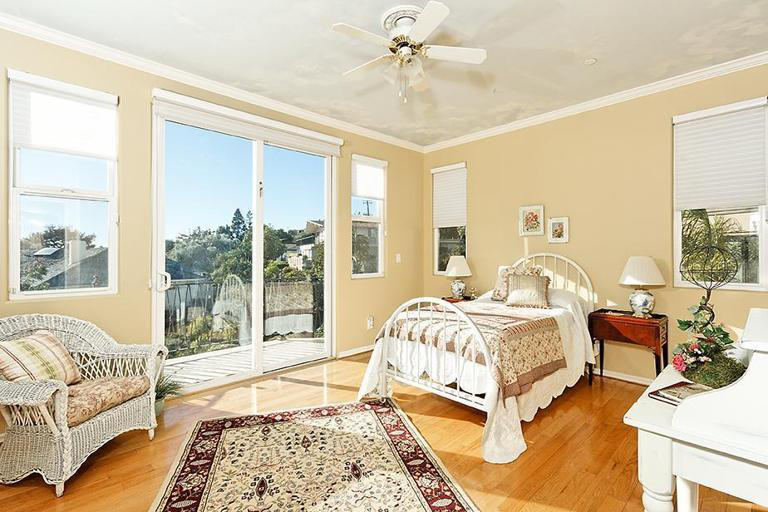

In [24]:
image = Image.open(r"image.jpg") 
image

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

# checkpoint = "segformer-b0-scene-parse-150"
# model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
model.to('cuda')

outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

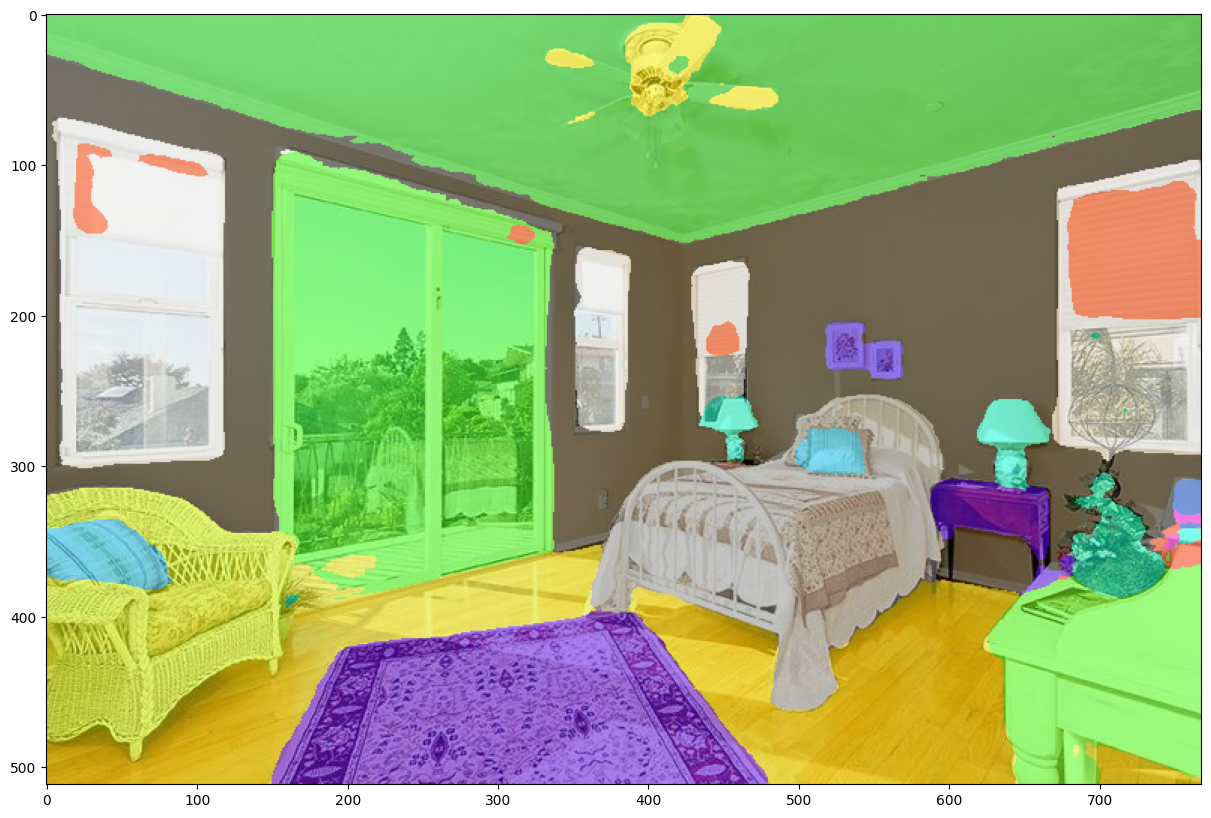

In [26]:
from color_palette import ade_palette

import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()